# Initialization

In [19]:
import torch
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset


from efficientnet_pytorch import EfficientNet

print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {DEVICE}")

PyTorch version: 2.3.0
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [20]:
# check folders in dataset folders
import os

PATH = "/Users/wyattcheang/retinal-model/preprocessed_data"
CLASSES = os.listdir(PATH)# Create a dictionary with elements as keys and their indices as values
INDEX_DICTS = {elem: idx for idx, elem in enumerate(CLASSES)}
CLASSES, INDEX_DICTS

(['CNV', 'DME', 'DRUSEN', 'NORMAL'],
 {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3})

In [21]:
SEED = 42
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Data Loading

### Load data into dataloader

In [22]:
import os
import pandas as pd

# Define the path to the directory containing the images organized by labels
path = "/Users/wyattcheang/retinal-model/preprocessed_data"

# Prepare an empty DataFrame to store images and respective labels
data = pd.DataFrame(columns=['Path', 'Label'])

# Iterate over each directory (each directory represents a label)
for label in os.listdir(path):
    # Skip .DS_Store file if present
    if label == ".DS_Store":
        continue
    
    # Construct the full path to the current label directory
    label_dir = os.path.join(path, label)
    
    # Initialize lists to store image data
    image_paths = []
    
    # Iterate over each image file in the current directory
    for image in os.listdir(label_dir):
        if image.endswith((".jpeg", ".jpg", ".png")):
            # Read the image data and add it to the list
            image_paths.append(os.path.join(label_dir, image))
        
    df = pd.DataFrame(data={"Path": image_paths})
    df["Label"] = label

    # Merge with existing data
    data = pd.concat([data, df], ignore_index=True)

# Display the DataFrame
print("Images loaded successfully into DataFrame")
print("Number of images:", len(data))
display(data)

Images loaded successfully into DataFrame
Number of images: 76902


,Path,Label
0,/Users/wyattcheang/retinal-model/preprocessed_...,CNV
1,/Users/wyattcheang/retinal-model/preprocessed_...,CNV
2,/Users/wyattcheang/retinal-model/preprocessed_...,CNV
3,/Users/wyattcheang/retinal-model/preprocessed_...,CNV
4,/Users/wyattcheang/retinal-model/preprocessed_...,CNV
...,...,...
76897,/Users/wyattcheang/retinal-model/preprocessed_...,NORMAL
76898,/Users/wyattcheang/retinal-model/preprocessed_...,NORMAL
76899,/Users/wyattcheang/retinal-model/preprocessed_...,NORMAL
76900,/Users/wyattcheang/retinal-model/preprocessed_...,NORMAL


In [23]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [24]:
def transform_image(image):
    image = image.float() / 255.0
    return image

def get_class_index(label):
    return CLASSES.index(label)

# Create custom dataset
custom_dataset = CustomImageDataset(annotations_file=data, 
                                    img_dir=path, 
                                    transform=transform_image, 
                                    target_transform=get_class_index)

# Split the dataset into training, validation, and testing sets
train_size = int(0.7 * len(custom_dataset))
val_size = int(0.15 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(custom_dataset, [train_size, val_size, test_size])

In [25]:
type(train_dataset), type(val_dataset), type(test_dataset)

(torch.utils.data.dataset.Subset,
 torch.utils.data.dataset.Subset,
 torch.utils.data.dataset.Subset)

In [26]:
# Access an example image and label from the training dataset
image, label = train_dataset[0]
print("Image shape:", image.shape)

Image shape: torch.Size([3, 224, 224])


In [27]:
# See the first training example
image, label = train_dataset[0]
image, label

(tensor([[[0.0118, 0.0235, 0.0196,  ..., 0.0314, 0.0353, 0.0157],
          [0.0118, 0.0392, 0.0510,  ..., 0.0314, 0.0353, 0.0275],
          [0.0235, 0.0510, 0.0706,  ..., 0.0510, 0.0510, 0.0431],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0157, 0.0118],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0078, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0000, 0.0000]],
 
         [[0.0118, 0.0235, 0.0196,  ..., 0.0314, 0.0353, 0.0157],
          [0.0118, 0.0392, 0.0510,  ..., 0.0314, 0.0353, 0.0275],
          [0.0235, 0.0510, 0.0706,  ..., 0.0510, 0.0510, 0.0431],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0157, 0.0118],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0078, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0000, 0.0000]],
 
         [[0.0118, 0.0235, 0.0196,  ..., 0.0314, 0.0353, 0.0157],
          [0.0118, 0.0392, 0.0510,  ..., 0.0314, 0.0353, 0.0275],
          [0.0235, 0.0510, 0.0706,  ...,

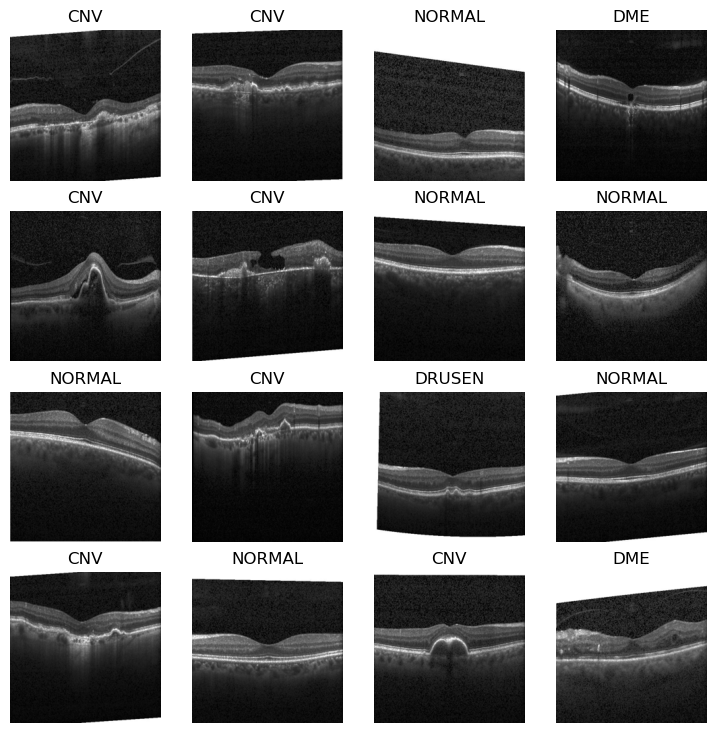

In [28]:
# Plot more images
torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range (1, rows*cols+1):
    random_index = torch.randint(0, len(train_dataset), size=(1,)).item()   # `item()` to get the value from tensor instead of tensor
    image, label = train_dataset[random_index]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.permute(1, 2, 0), cmap="gray")
    plt.title(CLASSES[label])
    plt.axis("off")

In [29]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn train dataset into DataLoader
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_dataloader, validation_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x14fe1a430>,
 <torch.utils.data.dataloader.DataLoader at 0x14fe1a4f0>)

In [30]:
# Check out what is inside the dataloader
print(f"DataLoader: {train_dataloader, test_dataloader, validation_dataloader}")
print(f"Length of DataLoader: {len(train_dataloader), len(test_dataloader), len(validation_dataloader)}")
print(f"Batch size of DataLoader: {train_dataloader.batch_size, test_dataloader.batch_size, validation_dataloader.batch_size}")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x14fe1a430>, <torch.utils.data.dataloader.DataLoader object at 0x14fe1a4f0>, <torch.utils.data.dataloader.DataLoader object at 0x14fe1a3d0>)
Length of DataLoader: (1683, 361, 361)
Batch size of DataLoader: (32, 32, 32)


### Reduced Version

In [13]:
from torch.utils.data import DataLoader, Subset

# Setup the batch size hyperparameter
BATCH_SIZE = 32

indices = torch.arange(350)
train_dataset = Subset(train_dataset, indices)
indices = torch.arange(75)
val_dataset = Subset(val_dataset, indices)
test_dataset = Subset(test_dataset, indices)

# Turn train dataset into DataLoader
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_dataloader, validation_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16b62feb0>,
 <torch.utils.data.dataloader.DataLoader at 0x105789340>)

In [14]:
# Check out what is inside the dataloader
print(f"DataLoader: {train_dataloader, test_dataloader, validation_dataloader}")
print(f"Length of DataLoader: {len(train_dataloader), len(test_dataloader), len(validation_dataloader)}")
print(f"Batch size of DataLoader: {train_dataloader.batch_size, test_dataloader.batch_size, validation_dataloader.batch_size}")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x16b62feb0>, <torch.utils.data.dataloader.DataLoader object at 0x105789340>, <torch.utils.data.dataloader.DataLoader object at 0x16b62fbe0>)
Length of DataLoader: (11, 3, 3)
Batch size of DataLoader: (32, 32, 32)


# Model 1: EfficientNet

### Define a model class

In [31]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class EffNet(nn.Module):
    def __init__(self, num_classes):
        super(EffNet, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0')  # Change the model type if needed
        
        # Modify the last fully connected layer
        in_features = self.model._fc.in_features  # Get the number of input features to the last layer

        # Replace the last fully connected layer with a new one
        self.model._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


### Create model instance, loss function, optimizer

In [32]:
effnet = EffNet(num_classes=len(CLASSES))
effnet

Loaded pretrained weights for efficientnet-b0


EffNet(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding(
     

In [33]:
from torchmetrics import Accuracy
lr = 0.001

optimizer = torch.optim.Adam(effnet.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = Accuracy(task="multiclass", num_classes=len(CLASSES)).to(DEVICE)

In [34]:
from helper import train_model, eval_model

### Train model

In [35]:
from helper import train_model, eval_model
from tqdm.auto import tqdm
from helper import timer

EPOCH = 5

start_time = timer()
history = {}
torch.manual_seed(42)
effnet.to(DEVICE)
for epoch in tqdm(range(1, EPOCH + 1), desc="Epoch", leave=True):
    train_result = train_model(model=effnet,
                               data_loader=train_dataloader,
                               loss_fn=loss_fn,
                               optimizer=optimizer,
                               accuracy_fn=accuracy_fn,
                               device=DEVICE,
                               epoch=epoch)
    
    eval_result = eval_model(model=effnet,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=DEVICE,
                             epoch=epoch)
    
    history[epoch] = {'train': train_result, 'eval': eval_result}
    print()

end_time = timer()

Elapsed time: 0.0 seconds


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 | Training:   0%|          | 0/1683 [00:00<?, ?it/s]

Epoch 1 | Evaluating:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 2 | Training:   0%|          | 0/1683 [00:00<?, ?it/s]

Epoch 2 | Evaluating:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 3 | Training:   0%|          | 0/1683 [00:00<?, ?it/s]

Epoch 3 | Evaluating:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 4 | Training:   0%|          | 0/1683 [00:00<?, ?it/s]

Epoch 4 | Evaluating:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 5 | Training:   0%|          | 0/1683 [00:00<?, ?it/s]

Epoch 5 | Evaluating:   0%|          | 0/361 [00:00<?, ?it/s]


Elapsed time: 1.1920928955078125e-06 seconds


In [36]:
temp = history

In [52]:
history

{1: {'train': {'name': 'EffNet',
   'result': [{'batch': 1, 'loss': 1.3823366165161133, 'accuracy': 0.28125},
    {'batch': 2, 'loss': 1.2906349897384644, 'accuracy': 0.453125},
    {'batch': 3, 'loss': 1.2135837872823079, 'accuracy': 0.5520833333333334},
    {'batch': 4, 'loss': 1.1381908655166626, 'accuracy': 0.59375},
    {'batch': 5, 'loss': 1.095494270324707, 'accuracy': 0.6125},
    {'batch': 6, 'loss': 0.9965325196584066, 'accuracy': 0.6614583333333334},
    {'batch': 7, 'loss': 0.9603689738682338, 'accuracy': 0.6651785714285714},
    {'batch': 8, 'loss': 0.9082866907119751, 'accuracy': 0.6796875},
    {'batch': 9, 'loss': 0.8711274464925131, 'accuracy': 0.6909722222222222},
    {'batch': 10, 'loss': 0.838722038269043, 'accuracy': 0.70625},
    {'batch': 11, 'loss': 0.7998117967085405, 'accuracy': 0.71875},
    {'batch': 12, 'loss': 0.8463632265726725, 'accuracy': 0.7135416666666666},
    {'batch': 13, 'loss': 0.8275327682495117, 'accuracy': 0.71875},
    {'batch': 14, 'loss': 0

In [82]:
import pandas as pd

# Flatten the nested dictionary structure and calculate progress
data = []

for epoch, epoch_data in history.items():
    for result_type, result in epoch_data.items():
        for i, result_entry in enumerate(result['result'], start=1):
            progress = (epoch - 1) + (i/ len(result['result']))
            data.append({
                'epoch': epoch,
                'batch': result_entry['batch'],
                'progress': progress,
                'type': result_type.capitalize(),
                'loss': result_entry['loss'],
                'accuracy': result_entry['accuracy']   
            })

# Create a DataFrame from the flattened data
df = pd.DataFrame(data)

# Display the DataFrame
df

,epoch,batch,progress,type,loss,accuracy
0,1,1,0.000594,Train,1.382337,0.281250
1,1,2,0.001188,Train,1.290635,0.453125
2,1,3,0.001783,Train,1.213584,0.552083
3,1,4,0.002377,Train,1.138191,0.593750
4,1,5,0.002971,Train,1.095494,0.612500
...,...,...,...,...,...,...
10215,5,357,4.988920,Eval,0.151746,0.953782
10216,5,358,4.991690,Eval,0.152987,0.953561
10217,5,359,4.994460,Eval,0.152617,0.953691
10218,5,360,4.997230,Eval,0.152243,0.953819


In [60]:
train_df = df[df['type'] == 'Train']
eval_df = df[df['type'] == 'Eval']

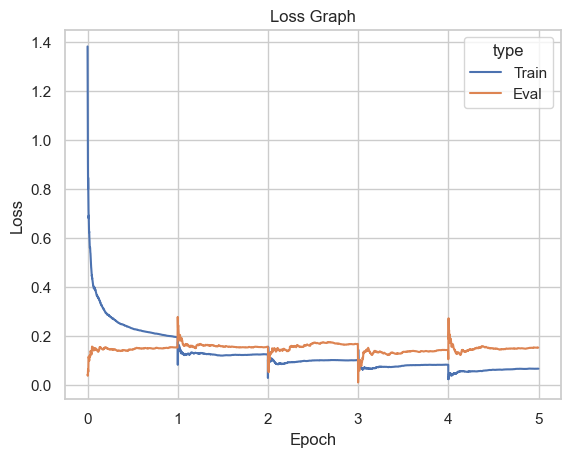

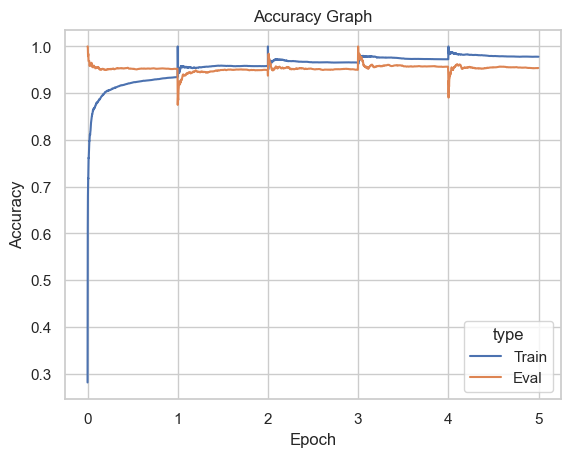

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the Loss
sns.set(style="whitegrid")
g = sns.lineplot(x='progress', y='loss', hue='type', data=df)
g.set(xlabel="Epoch", ylabel="Loss", title="Loss Graph")
plt.show()

# Plotting the Accuracy
sns.set(style="whitegrid")
g = sns.lineplot(x='progress', y='accuracy', hue='type', data=df)
g.set(xlabel="Epoch", ylabel="Accuracy", title="Accuracy Graph")
plt.show()

### Save model

#### save state_dict

In [41]:
from pathlib import Path

# Create a directory to save model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "effnetv2"
FILE_EXT = ".pth"
MODEL_SAVE_PATH = MODEL_PATH / f"{MODEL_NAME}{FILE_EXT}"

# Save the model
torch.save(effnet.state_dict(), MODEL_SAVE_PATH)

#### save history

In [42]:
# Save history dataframe into csv
PATH = Path("historys")
PATH.mkdir(parents=True, exist_ok=True)

FILE_EXT = ".csv"
HISTORY_SAVE_PATH = PATH / f"{MODEL_NAME}{FILE_EXT}"

# Save history dataframe
df.to_csv(HISTORY_SAVE_PATH, index=False)

### Load model

In [46]:
# Load the model
from pathlib import Path

# Create a directory to load model
MODEL_PATH = Path("models")
MODEL_NAME = "effnetv2.pth"

# Load the model
effnetv2 = EffNet(num_classes=len(CLASSES))
effnetv2.load_state_dict(torch.load(MODEL_PATH/MODEL_NAME))

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

# Model evaluation

In [68]:
def predict_model(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              device: torch.device = 'mps'):
    """eval the model

    Args:
        model (nn.Module): The model to test
        data_loader (torch.utils.data.DataLoader): The data loader for the testing data
        device (torch.device, optional): The device used to train the model. Defaults to 'mps'
    """
    
    model.eval()
    y_label, y_preds = [], []
    
    with torch.inference_mode():
        with tqdm(data_loader, desc=f"Making Prediction", leave=True) as t:
            for batch, (X, y) in enumerate(t):
                X, y = X.to(device), y.to(device)
                y_logits = model(X)
                y_pred = y_logits.softmax(dim=1).argmax(dim=1)
                
                y_label.append(y.cpu())
                y_preds.append(y_pred.cpu())
        
        return {
            "name": model.__class__.__name__,
            "target": y_label,
            "preds": y_preds,
        }

In [69]:
effnetv2.to(DEVICE)
result = predict_model(model=effnetv2,
                       data_loader=validation_dataloader,
                       device=DEVICE)

Making Prediction:   0%|          | 0/361 [00:00<?, ?it/s]

In [70]:
preds = torch.cat(result['preds'])
target = torch.cat(result['target'])

### Confusion Matrix

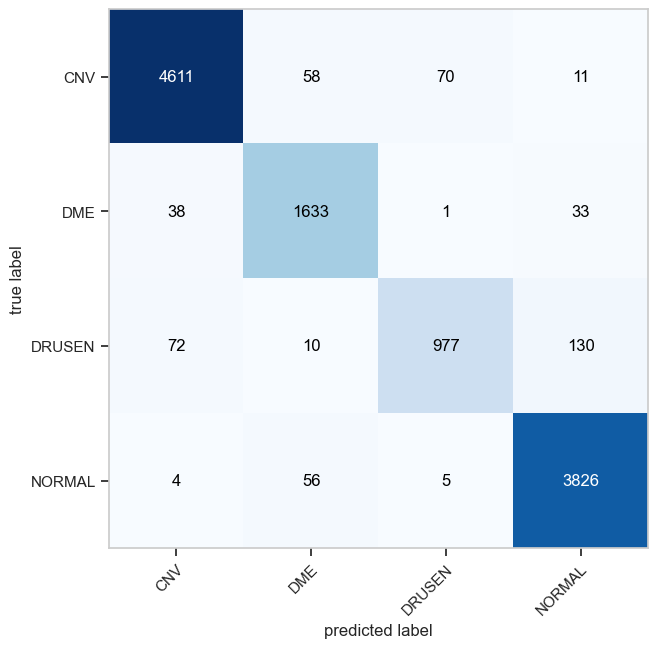

In [73]:
import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(CLASSES), task="multiclass")
confmat_tensor = confmat(preds=preds, 
                         target=target)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), 
                                class_names=CLASSES, 
                                figsize=(10, 7))

### Classification report

In [76]:
from sklearn.metrics import classification_report

num_classes = len(CLASSES)
target_names = ["Class {}".format(target) for i, target in enumerate(CLASSES)]
print(classification_report(target, preds, target_names=target_names))

              precision    recall  f1-score   support

   Class CNV       0.98      0.97      0.97      4750
   Class DME       0.93      0.96      0.94      1705
Class DRUSEN       0.93      0.82      0.87      1189
Class NORMAL       0.96      0.98      0.97      3891

    accuracy                           0.96     11535
   macro avg       0.95      0.93      0.94     11535
weighted avg       0.96      0.96      0.96     11535



In [80]:
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

metrics = MetricCollection([
            MulticlassAccuracy(len(CLASSES)), 
            MulticlassPrecision(len(CLASSES)), 
            MulticlassRecall(len(CLASSES)),
            MulticlassF1Score(len(CLASSES))
        ])

result = metrics(preds, target)
# Convert tensor values to Python scalars
result = {k: v.item() if isinstance(v, torch.Tensor) else v for k, v in result.items()}
# Convert the metrics dictionary to a DataFrame
df = pd.DataFrame(result.items(), columns=['Metric', 'Value'])
# Print the DataFrame
print(df)

                Metric     Value
0   MulticlassAccuracy  0.933375
1  MulticlassPrecision  0.947406
2     MulticlassRecall  0.933375
3    MulticlassF1Score  0.939485


In [ ]:
effnet

In [ ]:
import matplotlib.pyplot as plt

acc2 = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc2)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss2,'b',label='Train Loss')
axes[1].plot(epochs, val_loss,'r',label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
img = torchvision.utils.make_grid(images)

# Model Tuning